# Executive Summary and Problem Statement

Stylescout.com is a website which provides advertising and appointment booking services for various hair salons in New York City. The website conducts extensive reviews on vairous salons and has several articles on their blog about the latest hair styles and trends. In this project, the primary stakeholder is stylescout.com and the secondary stakeholders are the people who use their website's services.

I have been tasked by the creators of stylescout.com to build a classifier model using Natural Language Processing (NLP) and different machine learning techniques which can accurately predict language patterns that are related to male hairstyles or female hairstyles. They then intend to use this information to conduct search engine optimization to improve web traffic to articles and advertisements on their website which target one particular gender. Therefore, I have used posts from the subreddits 'r/femalehairadvice' and 'r/malehairadvice' to construct and test the models.

5 classifier models were created which accurately predicted whether a post originates from either 'malehairadvice' or 'femalehairadvice' subreddits and each of the models' pros and cons were explored. The models were constructed using 1500 of the top posts from this year (2021) scraped from reddit.com and then evaluated using 500 new posts scraped a week later. Taking all this into consideration, the models were evaluated before 1 was recommended to stylescout.com for their search engine optimization algorithm.

# Contents
- [Functions](#func)
    * [Functions for Text Cleaning](#functxt)
    * [Function for Gridsearch Cross Validation](#funcgs) 
    * [Function for searching Misclassified Documents](#funmisclass)
- [Dataframe Checking](#data)
- [Cleaning Text Data](#clean)
- [Gridsearch Cross Validation](#gs)
- [Pipelines](#pipe)
    * [Pipeline 1 - Logistic Regression with Count Vectorizer](#p1)
    * [Pipeline 2 - Logistic Regression with Tfidf Vectorizer](#p2)
    * [Pipeline 3 - Naive Bayes Multinomial with Tfidf Vectorizer](#p3)
    * [Pipeline 4 - Random Forest Classifier with Tfidf Vectorizer](#p4)
    * [Pipeline 5 - Support Vector Classifier with Tfidf Vectorizer](#p5)
- [Model Comparison](#compare)
    * [Count Vectorizer vs Tfidf Vectorizer](#vec)
    * [Models Evaluation](#eval)
    * [Model Selected](#select)
- [Conclusions and Recommendations](#conclude)
    * [Model Limitations and Future Work](#future)

In [1]:
# import relevant libraries
import pandas as pd
from bs4 import BeautifulSoup
import regex as re
from numpy import random

# Standard data science imports:
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords # Import the stopword list
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier#, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer

<a id='func'></a>
# Functions

I created functions to shorten repetitive tasks such as text cleaning, gridsearch cross-validation and various document/corpus checks to ensure those tasks are performed identically. Click [here](#data) to jump to the pre-modelling process.

<a id='functxt'></a>
## Functions for text cleaning

The functions below were used for cleaning the corpus by transforming the raw data into lemmatized and stemmed words. Certain strings were also removed as described in the function `text_to_words`. The functions were used in [Cleaning Text Data](#clean)

In [2]:
#Function to check if word exists in a given corpus
#Returns the document containing the word

def word_checker(list_of_words, word):
    result = []
    for i in list_of_words:
        if word in i:
            result.append(i)
    return result

In [3]:
#Function to check word pos tag
#Input is a list of strings containing individual words
#Returns the pos tag of the word in the format inputted into lemmatizer
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [4]:
# Function to convert a raw document to a list of documents to be processed by each pipeline
# The input is a single string, and 
# the output is a single string
def text_to_words(raw_text):
    
    
    # 1. Remove HTML.
    document = BeautifulSoup(raw_text).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", document)
    
    # 3. Convert to lower case, split into individual words.
    words_list = letters_only.lower().split()
    
    #4. Select words from stopwords for removal
    stops = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves',
                 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves',
                 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself',
                 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
                 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
                 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having',
                 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as',
                 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
                 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
                 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there',
                 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
                 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
                 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll',
                 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
                 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
                 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',
                 "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])
    #Words related to the subreddit and website were removed
    #Words directly indicating gender such as 'male' or 'female' were removed
    #'haircut' and 'hairstyle' were removed as they are common and do not connote a particular gender
    #'like' was removed as it was a commonly used term and also does not connote a particular gender. 
    #Furthermore, the meaning of 'like' changes depending on the context it is used
    removed_words = set(['www','http','com','woman','man','female','male','hair','advice','went','want','get',
                         'malehairadvice','femalehairadvice','reddit','haircut','hairstyle','style',
                         'like','likes','liked','liking'])
    
    # 5. Remove words manually.
    meaningful_words = [w for w in words_list if w not in stops]
    meaningful_words2 = [w for w in meaningful_words if w not in removed_words]
    
    #6. WordNet lemmatizer
    tags = nltk.pos_tag(meaningful_words2)
    wordnet_tagged = map(lambda x: (x[0], get_wordnet_pos(x[1])), tags)

    meaningful_words3 = [lemmatizer.lemmatize(word, pos = tag) if tag !='' else lemmatizer.lemmatize(word) for word, tag in wordnet_tagged ]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words3))

Most of the words from the default english stopwords library were used. The cell below denotes which words were excluded from cleaning in the corpus.

In [5]:
#replicate the stopwords selected in the function above
stops = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves',
                 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves',
                 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself',
                 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
                 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
                 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having',
                 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as',
                 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
                 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
                 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there',
                 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
                 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
                 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll',
                 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
                 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
                 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',
                 "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])

#The following words were not excluded from the default stopwords
for w in stopwords.words('english'):
    if w not in stops:
        print(w)

do
up
down
in
out
on
off
not


<a id='funcgs'></a>
## Function for GridsearchCV

The function below contains the function used for gridsearch. This was used in [Gridsearch Cross Validation](#gs) to optimize the hyperparameters for each model.

In [6]:
#Function which performs gridsearching over different pipelines
#inputs are lists containing the vectorizers, models and respective parameters for each pipeline
#outputs are lists containing the cross validated score and best parameters for each pipeline

def gridsearcher(vectorizer,model,parameters,X,y):
    cross_val_scores = []
    best_params = []
    cvec = CountVectorizer()
    tvec = TfidfVectorizer()
    log_reg = LogisticRegression(random_state = 25)
    nb = MultinomialNB()
    rf = RandomForestClassifier(random_state = 25)
    svc = SVC(random_state = 25)
    
    for n, p in enumerate(parameters):
        pipe = Pipeline([('vec', vectorizer[n]),
                         ('model', model[n])])
        gs = GridSearchCV(pipe,
                         param_grid = parameters[n],
                         cv = 5)
        gs.fit(X,y)
        cross_val_scores.append(gs.best_score_)
        best_params.append(gs.best_params_)
    return cross_val_scores, best_params

<a id='funmisclass'></a>
## Function for checking misclassified documents
This function was used to search for misclassified documents for each model for the purpose of [evaluation](#eval) of the different models.

In [7]:
#Function which searches the corpus for misclassifications for a particular model
#Inputs are the dataset, true class values and pipeline
#Outputs are lists of the false positives and false negatives separately along with their original and cleaned documents and probabilities

def misclassifier(X, y_true, pipeline):
    
    #Make predictions
    preds = pipeline.predict(X)
    
    #Get indices of the misclassified datapoints
    indices = [i for i in range(len(y_true)) if y_true.iloc[i] != preds[i]]
    
    #Get text for lemmatized + stemmed documents
    corpus = pd.DataFrame(data = {'Cleaned Documents':[text_to_words(doc) for doc in X],
                                  'Original Documents':[doc for doc in X]},
                          index = [X.index])
    
    #Get only the misclassified text
    false_predictions = corpus.iloc[indices]
    
    #Get the misclassification results
    false_pred_classes = [preds[i] for i in range(len(y_true)) if y_true.iloc[i] != preds[i]]
    
    #summarize misclassified text as DataFrame
    misclassified = false_predictions
    misclassified.loc[:,'Predicted Class'] = false_pred_classes
    
    #Separate misclassifications by false positives or false negatives
    misclassified_as_female = misclassified[misclassified.loc[:,'Predicted Class'] ==1]
    misclassified_as_male = misclassified[misclassified.loc[:,'Predicted Class'] ==0]
    
    #Add the probabilities that led to each false prediction
    misclassified_as_female.loc[:,'Probability Female'] = pipeline.predict_proba(misclassified_as_female.loc[:,'Original Documents'])[:,1]
    misclassified_as_male.loc[:,'Probability Male'] = pipeline.predict_proba(misclassified_as_male.loc[:,'Original Documents'])[:,0]
    
    return misclassified_as_female, misclassified_as_male

<a id='data'></a>
# Dataframe Checking

In [8]:
# Load dataframes

male_df = pd.read_csv('./malehairadvice.csv')
female_df = pd.read_csv('./femalehairadvice.csv')

#Load unseen data for model evaluation
unseen_male = pd.read_csv('./malehairadvice_unseen.csv')
unseen_female = pd.read_csv('./femalehairadvice_unseen.csv')

Another set of dataframes was scraped using 'new' posts on the respective subreddits to provide a larger testing set to evaluate the models. This is thereafter referred to the unseen dataset.

In [9]:
#Change setting so we can read the entire document for each row
pd.set_option("display.max_colwidth", None)

In [10]:
male_df.shape

(989, 2)

In [11]:
female_df.shape

(996, 2)

In [12]:
male_df.head()

,text,subreddit
0,Post-Quarantine: Shaved My Head. Thoughts?,malehairadvice
1,"Take notes, boys.",malehairadvice
2,Before and after: Covid Cut,malehairadvice
3,How did I do boys?,malehairadvice
4,A good way to remember how to correctly place toilet paper,malehairadvice


In [13]:
female_df.head()

,text,subreddit
0,[UPDATE!] Thank you to everyone who took the time to comment on my shag when I was feeling unsure. I changed up my glasses and styled it with curtain bangs instead and I am in LOVE with the way it looks now!!,femalehairadvice
1,"Asked advice yesterday, followed said advice and am loving the result!",femalehairadvice
2,"Update: I'm the trans girl from last week, I took the advice and got the bangs/eyebrow trim!",femalehairadvice
3,Finally made the chop! Before &amp; after,femalehairadvice
4,"Took some advice, left some out. Went in for a chop at couldn’t be happier",femalehairadvice


The imported dataframes for each respective subreddit contain a similar number of documents.

As this is a classification problem involving two classes, we assign the numbers 1 and 0 to each class. In this case, posts belonging to the subreddit r/femalehairadvice are assigned as class 1. On the other hand, posts belonging to subreddit r/malehairadvice are assigned as class 0.

In [14]:
#Combine subreddits and reset indices.
df_raw = pd.concat([male_df,female_df]).drop_duplicates().reset_index(drop = True)
unseen_raw = pd.concat([unseen_male,unseen_female]).drop_duplicates().reset_index(drop = True)

In [15]:
#Shuffle rows for unseen dataframe
unseen_raw = unseen_raw.sample(frac=1, random_state = 25).reset_index(drop=True)

In [16]:
#Posts from r/femalehairadvice are denoted as class 1, from r/malehairadvice are denoted as class 0
target_dict = {'femalehairadvice': 1, 'malehairadvice': 0}

**Note:** The secondary stakeholders are largely female, therefore r/femalehairadvice was set as class 1.

In [17]:
#Mapping the target variable.
df_raw['subreddit'] = df_raw['subreddit'].map(target_dict)
unseen_raw['subreddit'] = unseen_raw['subreddit'].map(target_dict)

In [18]:
df_raw

,text,subreddit
0,Post-Quarantine: Shaved My Head. Thoughts?,0
1,"Take notes, boys.",0
2,Before and after: Covid Cut,0
3,How did I do boys?,0
4,A good way to remember how to correctly place toilet paper,0
...,...,...
1980,Hi! I need your help. I decided to change my blond (second photo) to my original dark brown color. But my hair still tries to come back to the blonde color (first photo). Can you please recommend any good products with a brown coloring effect?,1
1981,Hair’s getting gray and unruly and mostly refuses to straighten (even with a CHI and products). HALP. Can I pull off a singer-known-as-Pink hairstyle with my big ol’ head?? Any other suggestions besides?,1
1982,Would a pixie cut suit me?,1
1983,"Okay so the first picture is of my hair. I want to change it up a bit but I'm afraid if I cut it shoulder length(like the rest of the pictures), it will be unruly and undefined. I wanna keep it low-maintenance(this includes no heat and without many products) do you think this style would suit me?",1


In [19]:
# Baseline score
df_raw['subreddit'].value_counts(normalize = True)

1    0.501763
0    0.498237
Name: subreddit, dtype: float64

Our baseline score is 50.2%. This is the accuracy to beat to know that our model works in predicting the classes.

In [20]:
#Checking the class distribution in the unseen dataset
unseen_raw['subreddit'].value_counts(normalize = True)

1    0.501002
0    0.498998
Name: subreddit, dtype: float64

In [21]:
unseen_raw.shape

(499, 2)

The unseen dataset contains 500 documents and is of a similar class distribution compared to the original dataset.

<a id='clean'></a>
# Cleaning Text Data


## Train test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_raw['text'],
                                                    df_raw['subreddit'],
                                                    test_size = 0.25,
                                                    random_state = 42)

In [23]:
#Checking the class distribution of our training set
y_train.mean()

0.5040322580645161

In [24]:
#Checking the class distribution of our test set
y_test.mean()

0.4949698189134809

In [25]:
#instantiate wordnet lemmatizer and porter stemmer
lemmatizer = WordNetLemmatizer()
p_stemmer= PorterStemmer()

In [26]:
# Initialize an empty list to hold the clean text
train_clean = []
test_clean = []

# For every document in our training set
for train_text in X_train:
    
    # Process documents using function then append to train_clean.
    train_clean.append(text_to_words(train_text))
    

# For every document in our testing set
for test_text in X_test:
    #Process documents using function then append to test_clean.
    test_clean.append(text_to_words(test_text))

I used [this function](#funclean) to clean the text data. 

Both lemmatization and stemming were used sequentially. This ensured that all words were lemmatized then converted to their respective stems, reducing the variety of the different forms of words.

Specific words removed included words that directly associated with the subreddit names such as 'male', 'female', 'hair' and 'advice'.

In [27]:
#Perform the same text cleaning process to the unseen dataset
X_unseen = unseen_raw[['text']]
y_unseen = unseen_raw['subreddit']

unseen_clean = []
for unseen_text in X_unseen['text']:
    unseen_clean.append(text_to_words(unseen_text))

In [28]:
#Check how the cleaned data looks like
train_clean[:10]

['do brown brown little orange undertone',
 'frizzy medium thick asian rarely use heat damp brush out apply oil use garnier in shampoo conditioner use use tresemme use do tame',
 'get first time in year thank guy',
 'short long right currently cut short time without bang',
 'beard think general consensus beard good kinda really wild top center vibe still hear always generally right hot not mild wild',
 'unsure bang not on washday feeling lose bit bored',
 'hi guy think get bang know type bang would best fit face shape naturally curly',
 'try grow out see itd look good didnt straight floppy poof out alot on side hoe cut look less weird',
 'recently start miss natural color nd picture color exactly color want in begin mess around purple shampoo bit take little bit orangeness still think something miss perfect',
 'really large ear need suggestion look good']

In [29]:
test_clean[:10]

['please help even leave house without hat anymore hairline atrocious make fun life detail in comment',
 'take subreddit cut shorter get bang thank',
 'inspire short ever gain new confidence also able reach goal inch go princess trust charity',
 'uhh cut bang know leave another please help',
 'anyway fix subhuman appearance bald good picture',
 'think go bald rest in peace lol',
 'idea',
 'tomorrow graduation picture recommendation shave facial',
 'current length bit product leave in last night gonna keep grow out style look in',
 'month definitely need fix']

<a id='gs'></a>
# Gridsearch Cross Validation

Several iterations of gridsearch cross validation were performed using various models and hyperparameters. The cells below contain a narrowed down set of models during the final iterations of gridsearch. Other models that were tested and excluded from this set due to overfitting are:
    - K nearest neighbors classifier
    - Decision tree classifier
    - Bagging classifier
    - Adaptive boost classifier
The above models were crossed out due to having significantly lower test accuracy scores as compared to their training accuracy scores.

In [30]:
#Instantiate vectorizers
cvec = CountVectorizer()
tvec = TfidfVectorizer()

In [31]:
#List of vectorizers used in gridsearch
vectorizers_list = [cvec,
                    tvec,
                    tvec,
                    tvec,
                    tvec]

In [32]:
#Instantiate models
log_reg = LogisticRegression(random_state = 25)
nb = MultinomialNB()
rf = RandomForestClassifier(random_state = 25)
svc = SVC(random_state = 25)

In [33]:
#List of models used in gridsearch
models_list = [log_reg,
               log_reg,
               nb,
               rf,
               svc]

In [ ]:
#Parameters used for each respective pipeline.

#Each pipeline contains 1 vectorizer and 1 model.

params_list = [{'vec__max_features': [400,500,600],# First pipeline countvectorizer, logisticregression
               'vec__min_df': [3,4,5],
               'vec__max_df': [0.15,0.2,0.25],
               'vec__stop_words' : [None,'english'],
               'vec__ngram_range': [(1,1),(1,2)],
               'model__C': [0.1,1,10],
               'model__max_iter': [500]},
              {'vec__max_features': [1100,1200,1300],#Second pipeline tfidfvectorizer, logisticregression
               'vec__min_df': [1,2,3],
               'vec__max_df': [0.05,0.1,0.15],
               'vec__stop_words' : [None,'english'],
               'vec__ngram_range': [(1,1),(1,2)],
               'model__C': [0.1,1,10],
               'model__max_iter': [1000]},
              {'vec__max_features': [500,600,700],#Third pipeline tfidfvectorizer, Naive bayes multinomial
               'vec__min_df': [2,3,4],
               'vec__max_df': [0.05,0.1,0.15],
               'vec__stop_words' : [None,'english'],
               'vec__ngram_range': [(1,1),(1,2)],
               'model__alpha': [0.6,0.7,0.8],
               'model__fit_prior': [True,False]},
              {'vec__max_features': [2100,2200,2300],#Fourth pipeline tfidfvectorizer, RandomForestClassifier
               'vec__min_df': [1,2,3],
               'vec__max_df': [0.05,0.1,0.15,0.2],
               'vec__stop_words' : [None,'english'],
               'vec__ngram_range': [(1,1),(1,2)],
               'model__criterion': ['gini','entropy'],
               'model__max_depth': [10,20,30],
               'model__n_estimators': [100,150,200,250]},
              {'vec__max_features': [2100,2200,2300],#Fith pipeline tfidfvectorizer, supportvectorclassifier
               'vec__min_df': [1,2,3],
               'vec__max_df': [0.05,0.1,0.15],
               'vec__stop_words' : ['english'],
               'vec__ngram_range': [(1,1),(1,2)],
               'model__C': [0.3,0.4,0.5],
               'model__kernel' : ['rbf','linear','poly'],
               'model__degree': [1,2,3],
               'model__gamma': ['scale']}]

Refer to [Function for Gridsearch Cross Validation](#funcgs) for function

In [126]:
cross_val_scores, best_params = gridsearcher(vectorizer = vectorizers_list,
                                             model = models_list,
                                             parameters = params_list,
                                             X = X_train,
                                             y = y_train)

In [127]:
cross_val_scores

[0.8038031319910515,
 0.8138725058188145,
 0.8286556843603824,
 0.7937134205590582,
 0.8172417689196214]

We have achieved cross validation scores of about 80% - 82% for our selected models. All of them beat the baseline accuracy score.

In [128]:
best_params

[{'model__C': 0.1,
  'model__max_iter': 500,
  'vec__max_df': 0.2,
  'vec__max_features': 500,
  'vec__min_df': 4,
  'vec__ngram_range': (1, 1),
  'vec__stop_words': 'english'},
 {'model__C': 1,
  'model__max_iter': 1000,
  'vec__max_df': 0.1,
  'vec__max_features': 1200,
  'vec__min_df': 1,
  'vec__ngram_range': (1, 1),
  'vec__stop_words': 'english'},
 {'model__alpha': 0.7,
  'model__fit_prior': False,
  'vec__max_df': 0.15,
  'vec__max_features': 700,
  'vec__min_df': 3,
  'vec__ngram_range': (1, 1),
  'vec__stop_words': 'english'},
 {'model__criterion': 'gini',
  'model__max_depth': 20,
  'model__n_estimators': 200,
  'vec__max_df': 0.15,
  'vec__max_features': 2300,
  'vec__min_df': 1,
  'vec__ngram_range': (1, 1),
  'vec__stop_words': 'english'},
 {'model__C': 0.4,
  'model__degree': 1,
  'model__gamma': 'scale',
  'model__kernel': 'rbf',
  'vec__max_df': 0.1,
  'vec__max_features': 2200,
  'vec__min_df': 1,
  'vec__ngram_range': (1, 1),
  'vec__stop_words': 'english'}]

<a id='pipe'></a>
# Pipelines
This section contains the different pipelines for the models and some exploration into their results. The parameters for each pipeline were set using the best parameters found during the gridsearch. The results for the models are discussed in depth in the [Model Comparison](#compare) section.

## Logistic Regression

The logistic regression model is a commonly used binary classifier and is used in pipelines 1 and 2. It assumes a linear relationship between features and the log-odds of class = 1.

To interpret the intercept and coefficients of the model, we need to first exponentiate the values. The result is interpreted as odds. For the exponentiated intercept, it is the likelihood of predicting class 1 as opposed to class 0 when the other predictors are = 0. For coefficients, the sign represents whether the feature increases or decreases the odds of predicting class 1. The magnitude of the exponentiated coefficient represents an increase in likelihood of predicting class 1 (or class 0 for negative coefficients).

<a id='p1'></a>
## Pipe 1 - Logistic Regression with Count Vectorizer

In [38]:
#Instantiate pipeline
pipe1 = Pipeline([
    ('vec', CountVectorizer()),
    ('model', LogisticRegression(random_state = 25))

])

In [39]:
#Check the best parameters found during gridsearch
best_params[0]

{'model__C': 0.1,
 'model__max_iter': 500,
 'vec__max_df': 0.2,
 'vec__max_features': 500,
 'vec__min_df': 4,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

Note that the regularization parameter C was set as 0.1 when the default value is 1. A smaller number such as in this case indicates stronger regularization. Regularization imposes a penalty of the coefficients of the model to reduce overfitting.

In [40]:
#Set parameters accordingly and fit to training set
pipe1.set_params(model__C = 0.1,
                model__max_iter = 500,
                vec__max_df = 0.2,
                vec__max_features = 500,
                vec__min_df = 4,
                vec__ngram_range = (1, 1),
                vec__stop_words = 'english')

pipe1.fit(train_clean, y_train)

Pipeline(steps=[('vec',
                 CountVectorizer(max_df=0.2, max_features=500, min_df=4,
                                 stop_words='english')),
                ('model',
                 LogisticRegression(C=0.1, max_iter=500, random_state=25))])

In [41]:
#Store train and test accuracy scores for comparison later
log_reg_count_train_score = pipe1.score(train_clean,y_train)
log_reg_count_test_score = pipe1.score(test_clean,y_test)

Confusion Matrix for Logistic Regression with Count Vectorization


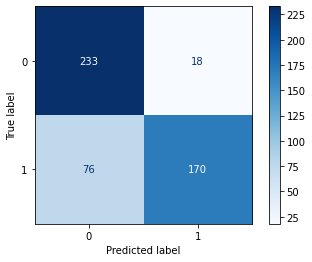

In [42]:
print('Confusion Matrix for Logistic Regression with Count Vectorization')
plot_confusion_matrix(pipe1,test_clean,y_test, cmap = 'Blues');

**Observation:** There much more false negatives than there are false positives.
False negatives are posts that were predicted to be from r/malehairadvice but were actually from r/femalehairadvice.

In [43]:
#Store misclassified documents for comparison later
misclassified_as_female1, misclassified_as_male1 = misclassifier(X = X_test,
                                                               y_true = y_test,
                                                               pipeline = pipe1)

C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

### Interpreting Intercept and Coefficients

In [44]:
#Get intercept for the logistic regression model
np.exp(pipe1['model'].intercept_)

array([0.60727381])

The exponentiated intercept represents a 0.607 increase in predicting r/femalehairadvice when the document contains no predictive features. This ties in with having more false negatives than false positives. The intercept may account for shorter documents with weak predictive features which were then misclassified to be from r/malehairadvice.

In [45]:
#Get coefficients for the logistic regression model
features1 = pipe1['vec'].get_feature_names()
coefficients1 = pipe1['model'].coef_
coef_df1 = pd.DataFrame(coefficients1,columns = features1).T
coef_df1.rename(columns = {0:'Coefficient'}, inplace = True)
coef_df1['Increase in odds'] = np.exp(coef_df1.loc[:,'Coefficient'])

The sign of the coefficient for logistic regression tells us whether the feature predicts r/femalehairadvice(positive) or r/malehairadvice(negative).
The coefficients themselves can be interpreted by exponentiating their values. The result represents an increase in odds of predicting r/femalehairadvice.

The following are the top 10 features which in predicting posts from r/femalehairadvice subreddit and r/malehairadvice subreddit respectively

In [46]:
#top 10 features predicting femalehairadvice
coef_df1.sort_values(by = 'Coefficient', ascending = False).head(10)

,Coefficient,Increase in odds
bang,1.719675,5.582716
color,1.304319,3.685177
pixie,0.850779,2.341470
love,0.789800,2.202955
bob,0.683290,1.980382
colour,0.653258,1.921793
chop,0.627223,1.872404
blonde,0.599795,1.821745
update,0.574431,1.776120
thank,0.560106,1.750858


The top feature is the word 'bang' which increases the odds of predicting r/femalehairadvice by 5.58 times.
**Observation:**
Strong predictive features include popular terms that describe female hairstyles such as 'bang', 'pixie', 'bob'
and hair colour 'color','colour','blond'

In [47]:
#top10 features predicting malehairadvice
coef_df1.sort_values(by = 'Coefficient', ascending = True).head(10)

,Coefficient,Increase in odds
barber,-0.810460,0.444654
beard,-0.743460,0.475466
recede,-0.439306,0.644483
guy,-0.425163,0.653663
hairline,-0.404280,0.667457
grow,-0.391789,0.675847
longer,-0.381856,0.682593
buzz,-0.359191,0.698241
know,-0.327748,0.720545
usually,-0.325110,0.722448


The top feature 'barber' changes the odds of predicting r/femalehairadvice by 0.445 times.
**Observation:** Men tend to be concerned with receding hairlines. Features such as 'beard' are strongly associated with men. Men also tend to refer to hairstylists as 'barber'

<a id='p2'></a>
## Pipe 2 -  Logistic Regression with Tfidf Vectorizer

In [48]:
#Instantiate pipeline
pipe2 = Pipeline([
    ('vec', TfidfVectorizer()),
    ('model', LogisticRegression(random_state = 25))

])

In [49]:
#Check best parameters found during gridsearch
best_params[1]

{'model__C': 1,
 'model__max_iter': 1000,
 'vec__max_df': 0.1,
 'vec__max_features': 1200,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [50]:
#Set parameters accordingly and fit to train dataset
pipe2.set_params(model__C= 1,
                 model__max_iter= 1000,
                 vec__max_df= 0.1,
                 vec__max_features= 1200,
                 vec__min_df= 1,
                 vec__ngram_range= (1, 1),
                 vec__stop_words= 'english')

pipe2.fit(train_clean, y_train)

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_df=0.1, max_features=1200,
                                 stop_words='english')),
                ('model',
                 LogisticRegression(C=1, max_iter=1000, random_state=25))])

In [51]:
#Store train and test accuracy scores for comparison later
log_reg_tfidf_train_score = pipe2.score(train_clean, y_train)
log_reg_tfidf_test_score = pipe2.score(test_clean, y_test)

Confusion Matrix for Logistic Regression with Tfidf Vectorization


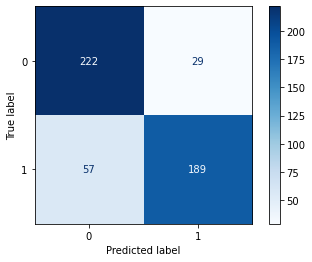

In [52]:
print('Confusion Matrix for Logistic Regression with Tfidf Vectorization')
plot_confusion_matrix(pipe2,test_clean,y_test, cmap = 'Blues');

In [53]:
#Store misclassified documents for comparison later
misclassified_as_female2, misclassified_as_male2 = misclassifier(X = X_test,
                                                               y_true = y_test,
                                                               pipeline = pipe2)

C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

### Interpreting intercept and coefficients

In [54]:
#Get intercept for logistic regression mdoel
np.exp(pipe2['model'].intercept_)

array([0.62064861])

The exponentiated intercept represents a 0.657 increase in predicting r/femalehairadvice when the document contains no predictive features.

In [55]:
#Get coefficients for the logistic regression model
features2 = pipe2['vec'].get_feature_names()
coefficients2 = pipe2['model'].coef_
coef_df2 = pd.DataFrame(coefficients2,columns = features2).T
coef_df2.rename(columns = {0:'Coefficient'}, inplace = True)
coef_df2['Increase in odds'] = np.exp(coef_df2.loc[:,'Coefficient'])

The following are the top 10 features which in predicting posts from r/femalehairadvice subreddit and r/malehairadvice subreddit respectively

In [56]:
coef_df2.sort_values(by = 'Coefficient', ascending = False).head(10)

,Coefficient,Increase in odds
bang,5.186504,178.842242
color,3.972480,53.116093
love,2.640218,14.016261
pixie,2.623608,13.785371
colour,2.281447,9.790838
blonde,2.086993,8.060637
bob,2.063674,7.874848
chop,1.697612,5.460894
dye,1.688176,5.409604
red,1.664538,5.283231


In [57]:
coef_df2.sort_values(by = 'Coefficient', ascending = True).head(10)

,Coefficient,Increase in odds
barber,-2.467369,0.084808
beard,-2.378340,0.092704
recede,-1.444641,0.235831
longer,-1.367526,0.254736
hairline,-1.314167,0.268698
know,-1.197686,0.301892
usually,-1.093983,0.334880
style,-1.055730,0.347938
buzz,-1.051656,0.349359
bald,-1.022986,0.359520


**Observation:** Like the first pipeline, the words associated with feminine hairstyles and hair coloring are strong predictors of r/femalehairadvice while words to do with facial hair and hairloss are strong predictors of r/malehairadvice.

There are some differences in the top 10 features as a result of the different vectorization methods. Count vectorization tokenizes features by their raw count within the corpus while Tfidf vectorization penalizes features that occur commonly throughout the corpus. For instance, the words 'long' and 'longer' appear to be among the top 10 predictors for r/malehairadvice here and not when using count vectorization. This means the words are relatively rare in the corpus and tend to come from men seeking advice about hair length. As men typically have shorter hair than women, men tend to be more sensitive to their hair length than women.

Another difference between the two vectorizers are the magnitude of the coefficients for the top features. Using Tfidf vectorizer produced higher coefficient values than for count vectorizer. This is likely a result of the regularization parameter used in the logistic regression model with count vectorization which dampened the effect of overfitting. Here we observe that the word 'bang' increases the odds of predicting r/femalehairadvice by 177.7 times as compared to 5.58 times when using count vectorizer.

<a id='p3'></a>
## Pipe 3 Naive Bayes Multinomial with Tfidf Vectorizer

The naive bayes classification algorithm uses bayes' theorem to predict the probability of r/femalehairadvice given words in the document. The algorithm assumes that features are independent of one another.

In [58]:
#Instantiate pipeline
pipe3 = Pipeline([
    ('vec', TfidfVectorizer()),
    ('model', MultinomialNB())

])

In [59]:
#check best parameters found during gridsearch
best_params[2]

{'model__alpha': 0.7,
 'model__fit_prior': False,
 'vec__max_df': 0.15,
 'vec__max_features': 700,
 'vec__min_df': 3,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [60]:
#Set parameters accordingly and fit to train dataset
pipe3.set_params(model__alpha = 0.7,
                 model__fit_prior = False,
                 vec__max_df = 0.15,
                 vec__max_features = 700,
                 vec__min_df = 3,
                 vec__ngram_range = (1, 1),
                 vec__stop_words = 'english')

pipe3.fit(train_clean, y_train)

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_df=0.15, max_features=700, min_df=3,
                                 stop_words='english')),
                ('model', MultinomialNB(alpha=0.7, fit_prior=False))])

In [61]:
#Store train and test accuracy scores for comparison later
nb_train_score = pipe3.score(train_clean,y_train)
nb_test_score = pipe3.score(test_clean,y_test)

Confusion Matrix for Naive Bayes Multinomial with Tfidf Vectorization


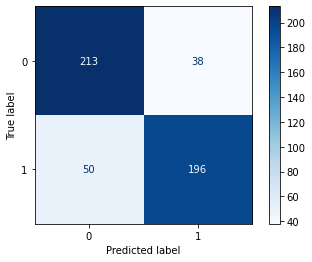

In [62]:
print('Confusion Matrix for Naive Bayes Multinomial with Tfidf Vectorization')
plot_confusion_matrix(pipe3,test_clean,y_test, cmap = 'Blues');

In [63]:
#Store misclassified documents for comparison later
misclassified_as_female3, misclassified_as_male3 = misclassifier(X = X_test,
                                                               y_true = y_test,
                                                               pipeline = pipe3)

C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

### Feature Log probabilities
The log probabilities of the each feature  returns the probability of the feature given a class. Since there are 2 classes, there are 2 log probabilities. It can be interpreted by exponentiating the values, then comparing the magnitudes of the probabilities. The class with the greater magnitude means that the feature predicts that particular class.

In [64]:
#Get feature log probabilities
nb_log_probs = pipe3['model'].feature_log_prob_
nb_log_probs

array([[-7.49416317, -7.8974569 , -7.25596188, ..., -6.79136085,
        -6.91707783, -6.87629553],
       [-6.84818102, -6.44319393, -7.28930992, ..., -8.11273888,
        -7.33842092, -6.93292013]])

In [65]:
#Get feature names
features3 = pipe3['vec'].get_feature_names()

In [66]:
#Combine feature names with their associated log_probs and include additional column to describe the difference betwneen
nb_features = pd.DataFrame({'words': features3,
                            'Prob_feature|male': np.exp(nb_log_probs[0]),
                            'Prob_feature|female': np.exp(nb_log_probs[1])})
nb_features['Difference'] = nb_features.loc[:,'Prob_feature|male']-nb_features.loc[:,'Prob_feature|female']

#top 10 features which predict malehairadvice
nb_features.sort_values(by = 'Difference', ascending = False).head(10)

,words,Prob_feature|male,Prob_feature|female,Difference
244,grow,0.018453,0.006715,0.011738
46,beard,0.009308,0.000300,0.009008
344,long,0.014929,0.006924,0.008006
40,barber,0.007333,0.000300,0.007033
247,guy,0.010686,0.004151,0.006534
78,buzz,0.008892,0.002425,0.006467
465,product,0.007643,0.002214,0.005428
319,know,0.009264,0.004085,0.005179
650,use,0.007556,0.002582,0.004973
252,hairline,0.005036,0.000600,0.004436


In [67]:
#top 10 features which predict femalehairadvice
nb_features.sort_values(by = 'Difference', ascending = True).head(10)

,words,Prob_feature|male,Prob_feature|female,Difference
39,bang,0.000588,0.021055,-0.020467
100,color,0.000351,0.013183,-0.012832
351,love,0.002065,0.010230,-0.008166
647,update,0.003201,0.010826,-0.007624
438,pixie,0.000351,0.007053,-0.006703
91,chop,0.002224,0.007363,-0.005139
61,bob,0.000351,0.005462,-0.005112
58,blonde,0.001106,0.006164,-0.005058
101,colour,0.000407,0.005274,-0.004866
134,curtain,0.000974,0.005715,-0.004742


**Observation:** Although the feature log probabilities is difficult to directly interpret, we see a similar pattern in the top features as compared to the logistic regression model.

<a id='p4'></a>
# Pipe 4 - Random Forest Classifier with Tfidf Vectorizer

The Random Forest Classifier is an ensemble method that uses bootsrap aggregating to repeatedly sample the training set with replacement and constructs multiple decision trees as a result. Additionally, a random subset of features is selected for each split within the decision tree algorithm to reduce the correlation between decision trees. Correlation between trees occurs when there are few features that are strong predictors of the target class as these features will be used in many of the bagged decision trees.

In [68]:
#Instantiate Pipeline
pipe4 = Pipeline([
    ('vec', TfidfVectorizer()),
    ('model', RandomForestClassifier(random_state = 25))

])

In [129]:
#check best parameters found during gridsearch
best_params[3]

{'model__criterion': 'gini',
 'model__max_depth': 20,
 'model__n_estimators': 200,
 'vec__max_df': 0.15,
 'vec__max_features': 2300,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [130]:
#Set parameters accordingly and fit to training set
pipe4.set_params(model__criterion = 'gini',
                 model__max_depth = 20,
                 model__n_estimators = 200,
                 vec__max_df = 0.15,
                 vec__max_features = 2300,
                 vec__min_df = 1,
                 vec__ngram_range = (1, 1),
                 vec__stop_words = 'english')

pipe4.fit(train_clean, y_train)

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_df=0.15, max_features=2300,
                                 stop_words='english')),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=200,
                                        random_state=25))])

In [131]:
#Store train and test accuracy scores for comparison later
rf_train_score = pipe4.score(train_clean,y_train)
rf_test_score = pipe4.score(test_clean,y_test)

Confusion Matrix for Random Forest Classifier with Tfidf Vectorization


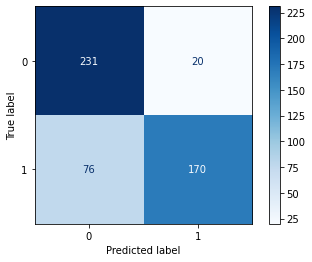

In [132]:
print('Confusion Matrix for Random Forest Classifier with Tfidf Vectorization')
plot_confusion_matrix(pipe4,test_clean,y_test, cmap = 'Blues');

In [133]:
#Store misclassified documents for comparison later
misclassified_as_female4, misclassified_as_male4 = misclassifier(X = X_test,
                                                               y_true = y_test,
                                                               pipeline = pipe4)

C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

### Feature importance

In the Random Forest Classifier algorithm, feature importance (or gini importance) is the feature's average impurity decrease calculated from all decision trees in the forest. When the decision tree is figuring out which split to make at a given node, it picks the split that maximizes the drop in gini impurity from the parent node to the child node. Therefore a higher feature importance shows how strong of a predictor that feature is of either class.

In [109]:
rf_importance = pipe4['model'].feature_importances_
features4 = pipe4['vec'].get_feature_names()
rf_features = pd.DataFrame({'Features' : features4,
                           'Importance' : rf_importance})

In [110]:
rf_features[rf_features['Importance']!=0].sort_values(by = 'Importance', ascending = False).head(10)

,Features,Importance
170,bang,0.093567
403,color,0.074074
1108,love,0.030315
1414,pixie,0.023250
194,beard,0.022983
249,bob,0.021285
173,barber,0.021241
1574,red,0.017127
2109,update,0.016147
404,colour,0.015892


The above table shows lists the features in descending order of importance.
**Observation:** The strongest 6 predictive features are associated with r/femalehairadvice. In the context of Tfidf vectorization, this suggests that there are more rare words which are strongly associated with female hair as compared to male hair.

<a id='p5'></a>
# Pipe 5 - Support Vector Classifier with Tfidf Vectorizer

The Support Vector Classifier (SVC) attempts to separate features by their class using a hyperplane(more than 3 features). The kernel trick used in this case was the radial basis kernel (rbf), which indicates that our features, when transformed into higher dimensions, are best separable with a radial or spherical hyperplane. The regularization hyperparameter C of the error term controls the trade-off between smooth decision boundaries and classifying the training points correctly. In this case, C was found to be optimized at 0.4 which indicates a greater priority for smooth decision boundaries.

In [76]:
#Instantiate Pipeline
pipe5 = Pipeline([
    ('vec', TfidfVectorizer()),
    ('model', SVC())

])

In [77]:
#check best parameters found during gridsearch
best_params[4]

{'model__C': 0.4,
 'model__degree': 1,
 'model__gamma': 'scale',
 'model__kernel': 'rbf',
 'vec__max_df': 0.1,
 'vec__max_features': 2200,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

**Observation:** Note that the model regularization parameter was set as 0.4, which indicates some level of regularization to reduce overfitting.

In [78]:
#Set parameters accordingly and fit to training set
pipe5.set_params(model__C = 0.4,
                 model__gamma = 'scale',
                 model__kernel = 'rbf',
                 model__probability = True,
                 vec__max_df = 0.1,
                 vec__max_features = 2200,
                 vec__min_df = 1,
                 vec__ngram_range = (1, 1),
                 vec__stop_words = 'english')

pipe5.fit(train_clean, y_train)

Pipeline(steps=[('vec',
                 TfidfVectorizer(max_df=0.1, max_features=2200,
                                 stop_words='english')),
                ('model', SVC(C=0.4, probability=True))])

In [79]:
#Store train and test accuracy scores for comparison later
svc_train_score = pipe5.score(train_clean,y_train)
svc_test_score = pipe5.score(test_clean,y_test)

Confusion Matrix for Support Vector Classifier with Tfidf Vectorization


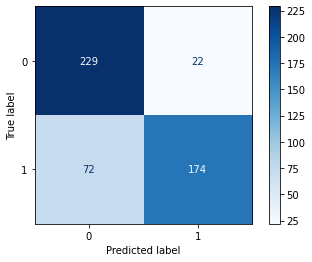

In [80]:
print('Confusion Matrix for Support Vector Classifier with Tfidf Vectorization')
plot_confusion_matrix(pipe5,test_clean,y_test, cmap = 'Blues');

In [81]:
misclassified_as_female5, misclassified_as_male5 = misclassifier(X = X_test,
                                                               y_true = y_test,
                                                               pipeline = pipe5)

C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

### Black Box model

The Support Vector Classifier, when using non-linear kernels, is essentially a black box model and making its parameters difficult to interpret. In this case, the RBF kernel was used which is better at estimating features in higher dimensions. 

<a id='compare'></a>
# Model Comparison

<a id='vec'></a>
## Count Vectorizer vs Tfidf Vectorizer

Count Vectorizer and Tfidf Vectorizer are transformers which tokenize the documents into numbers representing each feature. For the Count Vectorizer, features are transformed into the number of occurences for each feature per document. For the Tfidf Vectorizer, words that are common throughout the corpus are penalized. Therefore the features with greater emphasis are those which are rare throughout the corpus but common in a certain documents.

In [82]:
#Checking best parameters for pipeline 1
best_params[0]

{'model__C': 0.1,
 'model__max_iter': 500,
 'vec__max_df': 0.2,
 'vec__max_features': 500,
 'vec__min_df': 4,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [83]:
#Checking best parameters for pipeline 2
best_params[1]

{'model__C': 1,
 'model__max_iter': 1000,
 'vec__max_df': 0.1,
 'vec__max_features': 1200,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [84]:
#Instantiate vectorizers using the best parameters used in the logistic regression models
cvec = CountVectorizer(max_df = 0.2,
                       max_features = 500,
                       min_df = 4,
                       ngram_range = (1, 1),
                       stop_words = 'english')
tvec = TfidfVectorizer(max_df = 0.1,
                      max_features = 1200,
                      min_df = 1,
                      ngram_range = (1,1),
                      stop_words = 'english')

In [85]:
#Get the sparse matrix for the transformed features, add the values for each row and return an array.
response_c = cvec.fit_transform(train_clean,y_train).toarray().sum(axis = 0)
response_t = tvec.fit_transform(train_clean,y_train).toarray().sum(axis = 0)

In [86]:
#Get the tokens after vectorization
cvec_vocab = cvec.get_feature_names()
tvec_vocab = tvec.get_feature_names()

In [87]:
#Put together the features and their respective sums after transformation
cvec_features = pd.DataFrame(index = cvec_vocab, data = response_c).rename(columns = {0:'Count'})
tvec_features = pd.DataFrame(index = tvec_vocab, data = response_t).rename(columns = {0:'Importance'})

In [88]:
cvec_features.sort_values(by = 'Count', ascending = False).head(10)

,Count
cut,345
look,312
think,239
grow,199
long,178
bang,176
short,154
year,130
help,118
good,117


In [89]:
coef_df1.loc[['cut','look','think','grow','long','bang','short','year','help','good']]

,Coefficient,Increase in odds
cut,0.039365,1.040150
look,-0.186585,0.829788
think,0.142702,1.153386
grow,-0.391789,0.675847
long,-0.281080,0.754968
bang,1.719675,5.582716
short,0.183093,1.200926
year,-0.170850,0.842948
help,0.075890,1.078843
good,-0.150234,0.860507


**Observation:** For count vectorizer, we see that the count of each token is not necessarily reflective of their predictive value. For instance, of the top 10 words by count, only a handful show a significant increase (>25%) in odds for predicting r/femalehairadvice. Namely 'grow' and 'bang'.

In [90]:
tvec_features.sort_values(by = 'Importance', ascending = False).head(10)

,Importance
bang,46.390068
short,44.432571
suit,34.324548
help,32.805759
good,32.274122
thanks,31.889791
year,31.746841
guy,30.197300
suggestion,29.773470
update,29.121014


In [91]:
coef_df2.loc[['bang','short','suit','help','good','thanks','year','guy','suggestion','update']]

,Coefficient,Increase in odds
bang,5.186504,178.842242
short,-0.155377,0.856092
suit,0.386867,1.472360
help,-0.152946,0.858176
good,-0.515964,0.596925
thanks,0.596196,1.815201
year,-0.567716,0.566819
guy,-1.015773,0.362122
suggestion,-0.284518,0.752377
update,1.624534,5.076052


Since Tfidf penalizes words that are common throughout the corpus. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word. This helps to adjust for the fact that some words appear frequently throughout the corpus. Therefore the sum of each token value is a rough measure of the relative importance of that token within the corpus.

**Observation:** Several tokens from the top 10 highest counts from count vectorizer do not appear in the top 10 tokens by importance from the tfidf vectorizer. The words 'cut', 'look', 'think', 'grow' and 'long' seem to be of relative low importance in the corpus.

Of the top 10 tokens by importance from tfidf vectorization, many of the features show a significant (>25%) increase in odds of predicting r/femalehairadvice. For instance, 'bang' has a 177.6 times increase in odds of predicting r/femalehairadvice, likewise, 'guy' decreases the odds to 0.366 times.

### Tfidf Vectorizer for Search Engine Optimization

The Tfidf Vectorizer was selected over Count Vectorizer as it reduces the importance of words that may not provide predictive value but are commonly used. This is more suited for building search engine optimization algorithms as it emphasizes words that frequently used for a given classification type. 

<a id='eval'></a>
## Model Evaluation

### Testing on unseen data from new posts

Hair styles and trends for each gender change over time. To test the robustness of the models, I scraped 500 new posts from both subreddits to score the models and evaluate how they handle a larger sample of unseen data.

In [134]:
#Evaluating model performance on unseen data
unseen_score1 = pipe1.score(unseen_clean, y_unseen)
unseen_score2 = pipe2.score(unseen_clean, y_unseen)
unseen_score3 = pipe3.score(unseen_clean, y_unseen)
unseen_score4 = pipe4.score(unseen_clean, y_unseen)
unseen_score5 = pipe5.score(unseen_clean, y_unseen)

In [139]:
#Rounding scores to 3sf and creating dictionary to convert to dataframe
all_model_scores = {'Log Reg Count Vectorizer' : [round(log_reg_count_train_score, 3),
                                                  round(log_reg_count_test_score,3),
                                                  round(unseen_score1,3),
                                                  round(log_reg_count_train_score-log_reg_count_test_score,3),
                                                  round(log_reg_count_train_score-unseen_score1,3),
                                                  round((log_reg_count_train_score-log_reg_count_test_score) + (log_reg_count_train_score-unseen_score1),3)
                                                  ],
                   'Log Reg Tfidf Vectorizer' : [round(log_reg_tfidf_train_score,3),
                                                 round(log_reg_tfidf_test_score,3),
                                                 round(unseen_score2,3),
                                                 round(log_reg_tfidf_train_score-log_reg_tfidf_test_score,3),
                                                 round(log_reg_tfidf_train_score-unseen_score2,3),
                                                 round((log_reg_tfidf_train_score-log_reg_tfidf_test_score) + (log_reg_tfidf_train_score-unseen_score2),3)
                                                 ],
                   'Naive Bayes Multinomial': [round(nb_train_score,3),
                                               round(nb_test_score,3),
                                               round(unseen_score3,3),
                                               round(nb_train_score-nb_test_score,3),
                                               round(nb_train_score-unseen_score3,3),
                                               round((nb_train_score-nb_test_score) + (nb_train_score-unseen_score3),3)
                                               ],
                   'Random Forest Classifier' : [round(rf_train_score,3),
                                                 round(rf_test_score,3),
                                                 round(unseen_score4,3),
                                                 round(rf_train_score-rf_test_score,3),
                                                 round(rf_train_score-unseen_score4,3),
                                                 round((rf_train_score-rf_test_score) +(rf_train_score-unseen_score4),3)
                                                 ],
                   'Support Vector Classifier' : [round(svc_train_score,3),
                                                  round(svc_test_score,3),
                                                  round(unseen_score5,3),
                                                  round(svc_train_score-svc_test_score,3),
                                                  round(svc_train_score-unseen_score5,3),
                                                  round((svc_train_score-svc_test_score) + (svc_train_score-unseen_score5),3)
                                                  ]}

In [140]:
all_model_scores

{'Log Reg Count Vectorizer': [0.85, 0.811, 0.792, 0.039, 0.059, 0.098],
 'Log Reg Tfidf Vectorizer': [0.901, 0.827, 0.798, 0.074, 0.104, 0.178],
 'Naive Bayes Multinomial': [0.891, 0.823, 0.814, 0.068, 0.078, 0.146],
 'Random Forest Classifier': [0.898, 0.807, 0.782, 0.091, 0.116, 0.207],
 'Support Vector Classifier': [0.935, 0.811, 0.796, 0.124, 0.139, 0.263]}

In [141]:
score_comparison = pd.DataFrame(data = all_model_scores, index = ['Train Score', 'Test Score','Unseen Score','Train/Test Accuracy Drop','Test/Unseen Accuracy Drop', 'Total Accuracy Drop'])
print('Table of Accuracy scores for the different models')
score_comparison

Table of Accuracy scores for the different models


,Log Reg Count Vectorizer,Log Reg Tfidf Vectorizer,Naive Bayes Multinomial,Random Forest Classifier,Support Vector Classifier
Train Score,0.850,0.901,0.891,0.898,0.935
Test Score,0.811,0.827,0.823,0.807,0.811
Unseen Score,0.792,0.798,0.814,0.782,0.796
Train/Test Accuracy Drop,0.039,0.074,0.068,0.091,0.124
Test/Unseen Accuracy Drop,0.059,0.104,0.078,0.116,0.139
Total Accuracy Drop,0.098,0.178,0.146,0.207,0.263


**Observation:** All 5 models had a significant improvement in accuracy scores on the training dataset as compared to the baseline score (50.2%). The top 3 models which showed highest test accuracies are:

1) Naive Bayes Multinomial
2) Logistic Regression
3) Support Vector Classifier

We can analyse the `Train/Test Accuracy Drop` to gauge the extent of overfitting for each model. Having a higher accuracy drop means greater overfitting which is something we wish to avoid to ensure that our model can generalize better over new data. This can be an important issue with regards to hair styles and trends as they change over time. To further test the robustness of our models, a second test was performed using a dataset scraped from new posts from each subreddit. The `Test/Unseen Accuracy Drop` is then computed to measure each model's robustness when accounting for the latest hair trends.

The top 3 models which show the most robust performance (ie. lowest total accuracy drop) are:

1) Naive Bayes Multinomial
2) Logistic Regression
3) Random Forest Classifier

Since our secondary stakeholders are made up of mostly female, we want the model which is optimized for the **True Positive Rate** which means we want to maximize the **sensitivity (or recall)** of the model.

In [138]:
print('classification report for Logreg with Cvec \n' + classification_report(y_test,pipe1.predict(test_clean)))
print('classification report for Logreg with Tvec \n' + classification_report(y_test,pipe2.predict(test_clean)))
print('classification report for Naive Bayes \n' + classification_report(y_test,pipe3.predict(test_clean)))
print('classification report for Random Forest \n' + classification_report(y_test,pipe4.predict(test_clean)))
print('classification report for Support Vector \n' + classification_report(y_test,pipe5.predict(test_clean)))

classification report for Logreg with Cvec 
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       251
           1       0.90      0.69      0.78       246

    accuracy                           0.81       497
   macro avg       0.83      0.81      0.81       497
weighted avg       0.83      0.81      0.81       497

classification report for Logreg with Tvec 
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       251
           1       0.87      0.77      0.81       246

    accuracy                           0.83       497
   macro avg       0.83      0.83      0.83       497
weighted avg       0.83      0.83      0.83       497

classification report for Naive Bayes 
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       251
           1       0.84      0.80      0.82       246

    accuracy                           0.82       497
 

From the recall values for each model with respect to predicting class = 1, we observe that models with the best sensitivity are:
1) Naive Bayes Multinomial (80%)
2) Logistic Regression (76%)

**Observation:** The recall with respect to class = 0 is consistently higher than the recall with respect to class = 1. This is consistent with the fact that there are more false negatives than false positives from our predictions. This means many of the misclassifications were actually from r/femalehairadvice but were falsely predicted to be from r/malehairadvice. Now that we have narrowed the models down to 2, we can explore this further by looking at the documents which were misclassified by both of these models.

In [97]:
#Get false negatives from pipe 2 and 3
list(set(misclassified_as_male2['Cleaned Documents']) & 
     set(misclassified_as_male3['Cleaned Documents']))

['get stir crazy try grow out dye come out far dark cut off start bang',
 'get soon know direction go maybe look change please advise',
 'back blonde undercut p please ignore fact still wet in picture excite wait dry',
 'castor oil make fine straight wavyhi everyone lurk love information useless recently use castor oil on fine straight give really nice wave first time think would share experience in case help anyone fine generally straight little wavy in certain circumstance never able control wave though tried curly girl method experiment sort product tend dry frizzy product control frizz way heavy make greasy even leave in conditioner not really option recently use castor oil on get nice wave first time picture buy b well organic cold press castor oil put on wet shampoo conditioner let sit min shampooed condition normal expectation sleep on wet wake up nice wave on day two look greasy yet call win x b x b http preview redd lpcsc f nkk jpg width format pjpg auto webp c cd b ecd eb',
 

In [98]:
#Get false positives from pipe 2 and 3
list(set(misclassified_as_female2['Cleaned Documents']) & 
     set(misclassified_as_female3['Cleaned Documents']))

['hello baby face advice',
 'get chop off not long ago pretty happy result',
 'update hopefully cool post finally get big glass think make difference thanks everyone help',
 'long beach wave fun last',
 'would suit see second photo',
 'do fix thing',
 'thanks inspiration guy',
 'long awhile ready chop off do one pic down one pic back face shape visible thinner face many others feel fivehead lmk post profile shot',
 'need help current',
 'confidence wear out personally love do guy think',
 'would ask',
 'post little ago update',
 'slick back year decide on drastic change needless say fricking love']

A major limitation in our classification problem is the length of the documents. Several of the misclassifications are short documents containing 5 words or less. This can easily lead to misclassifications as there is simply not enough words in the document to make an accurate prediction.

Another limitation is the feature coefficients/importance. From the analyses of the individual pipelines, we observe that features that are associated with r/femalehairadvice tend to be words that describe a variety of hairstyles (pixie, bob, bangs) and hair colors (color, colour, blonde, red,black, balayage, brown). On the other hand, for r/malehairadvice, the words that describe hairstyles tend to be limited (beard, buzz, recede, hairline, bald). This is reflective of the difference in types of specialized hair styles and treatments catered to women. As a result, the vocabulary bank which describes female hair is much more varied than male hair.

In [99]:
#Top features which predit r/femalehairadvice for logistic regression model
coef_df2.sort_values(by = 'Coefficient', ascending = False).head(15)

,Coefficient,Increase in odds
bang,5.186504,178.842242
color,3.972480,53.116093
love,2.640218,14.016261
pixie,2.623608,13.785371
colour,2.281447,9.790838
blonde,2.086993,8.060637
bob,2.063674,7.874848
chop,1.697612,5.460894
dye,1.688176,5.409604
red,1.664538,5.283231


In [100]:
#Top features which predict r/malehairadvice for logistic regression model
coef_df2.sort_values(by = 'Coefficient', ascending = True).head(15)

,Coefficient,Increase in odds
barber,-2.467369,0.084808
beard,-2.378340,0.092704
recede,-1.444641,0.235831
longer,-1.367526,0.254736
hairline,-1.314167,0.268698
know,-1.197686,0.301892
usually,-1.093983,0.334880
style,-1.055730,0.347938
buzz,-1.051656,0.349359
bald,-1.022986,0.359520


In [101]:
#Top features which predict r/femalehairadvice for naive bayes model
nb_features.sort_values(by = 'Difference', ascending = True).head(15)

,words,Prob_feature|male,Prob_feature|female,Difference
39,bang,0.000588,0.021055,-0.020467
100,color,0.000351,0.013183,-0.012832
351,love,0.002065,0.010230,-0.008166
647,update,0.003201,0.010826,-0.007624
438,pixie,0.000351,0.007053,-0.006703
91,chop,0.002224,0.007363,-0.005139
61,bob,0.000351,0.005462,-0.005112
58,blonde,0.001106,0.006164,-0.005058
101,colour,0.000407,0.005274,-0.004866
134,curtain,0.000974,0.005715,-0.004742


In [102]:
#Top features which predict r/malehairadvice for naive bayes model
nb_features.sort_values(by = 'Difference', ascending = False).head(15)

,words,Prob_feature|male,Prob_feature|female,Difference
244,grow,0.018453,0.006715,0.011738
46,beard,0.009308,0.000300,0.009008
344,long,0.014929,0.006924,0.008006
40,barber,0.007333,0.000300,0.007033
247,guy,0.010686,0.004151,0.006534
78,buzz,0.008892,0.002425,0.006467
465,product,0.007643,0.002214,0.005428
319,know,0.009264,0.004085,0.005179
650,use,0.007556,0.002582,0.004973
252,hairline,0.005036,0.000600,0.004436


<a id='select'></a>
## Model selection

In [103]:
score_comparison[['Log Reg Tfidf Vectorizer','Naive Bayes Multinomial']]

,Log Reg Tfidf Vectorizer,Naive Bayes Multinomial
Train Score,0.901,0.891
Test Score,0.827,0.823
Unseen Score,0.798,0.814
Train/Test Accuracy Drop,0.074,0.068
Test/Unseen Accuracy Drop,0.029,0.009
Total Accuracy Drop,0.104,0.078


In [104]:
print('classification report for Logreg with Tvec \n' + classification_report(y_test,pipe2.predict(test_clean)))
print('classification report for Naive Bayes \n' + classification_report(y_test,pipe3.predict(test_clean)))

classification report for Logreg with Tvec 
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       251
           1       0.87      0.77      0.81       246

    accuracy                           0.83       497
   macro avg       0.83      0.83      0.83       497
weighted avg       0.83      0.83      0.83       497

classification report for Naive Bayes 
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       251
           1       0.84      0.80      0.82       246

    accuracy                           0.82       497
   macro avg       0.82      0.82      0.82       497
weighted avg       0.82      0.82      0.82       497



Using the aforementioned criteria of minimizing total accuracy drop and maximizing recall with respect to class 1, I selected the Naive Bayes Multinomial model for deployment for stylescouts.com. While this model performed well in this process, it is worth noting that the Naive Bayes model assumes feature independence which may prove disadvantageous especially for processing text data. In reality, it is near impossible to obtain a dataset with features that are mutually independent.

<a id='conclude'></a>
# Conclusions and Recommendations

The **Tfidf Vectorization** method is recommended for search engine optimization (SEO) purposes as it penalizes common words that have little predictive value as opposed to Count Vectorization. This emphasize words of higher importance in the predictive task.

The **Naive Bayes Multinomial model** was the best performing model out of the 5 in terms of:
- Gridsearch and train Accuracy
    * Good at making correct predictions
- Robustness (test and unseen accuracy drop)
    * Good at generalizing to new data (eg. latest trends)
- Sensitivity
    * Minimize false negatives (predicting male when actually female)
    
Therefore it is recommended to deploy the above machine learning algorithm for SEO in the stylescout website.

Some advantages of using the Naive Bayes model include:
- It requires a small amount of training data to estimate the test data. So the training period takes less time.
- It can make probabilistic predictions which are interpretable.
- It is highly scalable. It scales linearly with the number of predictor features and data points.

<a id='future'></a>
## Model Limitations and Future Work

### Changes in trends
A major limitation to the model is the fact that trends evolve and therefore popular hairstyles change throughout time. 

One suggestion is to retrain the model each year, using the top posts on the respective subreddits by year, to account for these differences.

Another suggestion is to implement deep learning algorithms for unsupervised machine learning to build a more robust model capable of handling new, unlabelled data. This is currently not in the scope of this project and is an area for future work.